Songs of the Solar Wind

by Elaina Hill and Jaye Verniero, NASA Goddard Space Flight Center, 34elainah@gmail.com, jaye.l.verniero@nasa.gov

All information in the universe is a wave. One only needs to extract these waves and interpret their meaning. In this tutorial, we show how to analyze the wave and proton energy flux data from the Parker Solar Probe (PSP) FIELDS and SWEAP instruments using machine learning (http://parkersolarprobe.jhuapl.edu/) (https://fields.ssl.berkeley.edu/instruments/).

Spacecraft data analysis is primarily contingent on the user understanding how the data is stored, subsequently learning how to best orchestrate it in order to extract patterns (signals).

We will use librosa to import and analyze audio data. You will simply need to insert a WAV file to begin. Librosa has the ability to section the entire audio file into regions of interest (ROIs) using MFCCs. MFCCs is a way to capture the important sounds in an audio signal in a way that a computer can understand and work with. First, it breaks down audio into small pieces, then it focuses on important parts by mimicing human hearing and its innate ability to focus and sound out unimportant sounds. Next, it simplifies the Details. Each short segment of sound is turned into a set of numbers that represent the most important parts of the sound. These numbers are the MFCCs. These numbers can be used by an AI to detect and cluster (https://github.com/librosa/librosa). 

We will use KMeans clustering. K-means clustering is an unsupervised machine learning technique that characterizes data utilizing an iterative process to converge on optimal cluster centriods. In this tutorial, we demonstrate application of K-means clustering to audified fluxgate magnetometer data from the FIELDS instrument on PSP, specifically targeting dynamic regions near the HCS. We show that the evolution of the proton energy flux, measured by the SWEAP instrument suite, also coincides with these identified clusters. We find that unsupervised learning via K-means offers a viable workflow for automated feature detection in audified time series data, without need for prior labels (https://github.com/scikit-learn/scikit-learn).

In this tutorial, we will also use the CDF reader that is built into a library called PySPEDAS (https://pyspedas.readthedocs.io/en/latest/), an implementation of the Space Physics Environment Data Analysis Software (SPEDAS) framework in Python.

The SPEDAS framework is written in Interactive Data Language (IDL) and contains data loading, data analysis and data plotting tools for various scientific missions (NASA, NOAA, etc.) and ground magnetometers. However, the IDL coding language is not free and not as ubiquituous amongst scientists outside the space physics discipline. There is a large movement in the space physics community toward "Open Science," meaning that folks share more code and data with eachother to better acheive a common goal. Since Python is free and more universal, space scientists are now working on converting their scripts from IDL to Python which has been better enabled by the recent development of PySPEDAS. Here is an example tutorial of pySPEDAS (https://github.com/heliophysicsPy/summer-school/blob/main/pyspedas-tutorial/PySPEDAS_Summer_School_2022.ipynb). For more documentation on using Python for space physics data analysis, see here: https://github.com/heliophysicsPy .

Step 1

First, we will import the nessasary libraries librosa, numpy, pandas, matplotlib and sklearn for KMeans clustering and PCA, and get the inital MFCCs and Clusters using these links:(https://github.com/pandas-dev/pandas)(https://github.com/numpy/numpy)(https://github.com/matplotlib)

Follow all steps under the Installation Section of these packages.

In [20]:
import librosa
import librosa.display
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.decomposition import PCA

Next, we will load the audio wav file using librosa.

First, you will assign the output of the wav file to two variables y and sr, y will contain the audio time series (the waveform of the audio), and sr will contain the sample rate of the audio file.

sr=None means that the function will load the audio file with its original sample rate. If you wanted to resample the audio to a different sample rate, you could specify that sample rate instead of None.

In [21]:
# Load the audio file
file_path = 'E8_Jaye_PSP_FLD_L2_MAG_RTN_2021_04_29_0730_to_0830_001_44100.wav'
y, sr = librosa.load(file_path, sr=None)

Now, you will extract the mfccs using the librosa function, librosa.feature.mfcc. 

In [22]:
# Extract features (e.g., MFCCs)
mfcc = librosa.feature.mfcc(y=y, sr=sr)

Now, we will Use K-means clustering on the MFCC features. 

You can specify the number of clusters using the n_clusters variable. 

random_state=0: This sets the seed for the random number generator. It ensures that the results are reproducible. Using the same random_state value will produce the same results each time you run the algorithm, given the same input data. Changing this will change the cluster results, if you choose to test different clustering results. 

In [23]:
# Use K-means clustering on MFCC features
n_clusters = 10  # Number of clusters (adjust as needed)
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(mfcc.T)  # Transpose to fit samples x features

Next, we will get the initial centroids. A centroid is the mean position of all the points in a cluster. 

It represents the center of the cluster. It contains the coordinates of a cluster. 

In [24]:
# Get initial centroids
initial_centroids = kmeans.cluster_centers_

Now, we will Perform PCA for dimensionality reduction using the fit_transform function on the mfccs and the clusters created earlier. 

You can specify the number of dimensions you want using n_components. Two is recommended because it is easy to plot in python. 

You can print these centroid coordinantes if you wish. 

In [25]:
# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
mfcc_pca = pca.fit_transform(mfcc.T)  # Transpose to fit samples x features

# Get model centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)

# Uncomment the next two lines to print the centroid coordinates. 
#'for i in range(n_clusters):
#    print(f'initial centroid #{i+1} :', initial_centroids[i, :], 'model centroid #{i+1}:', centroids_pca[i, :])

Here you need to calculate the duration of each audio frame. 

512 is librosa's recommended number for balance when performing the Short-Time Fourier Transform. The sample rate sr is 44,100 Hz, and the hop_length is 512 which means each frame of audio is approximately 0.0116 seconds long.

In [26]:
# Calculate the duration of each audio frame
hop_length = 512  # Default hop length used by librosa for STFT
frame_duration = hop_length / sr  # Duration of each frame in seconds

Here we create a dataframe to look at eaach audio frame and which cluster it is a part of this is helpful for listening, investigating and naming each cluster accordingly.

In [27]:
# Create a DataFrame with start and end times for each frame and its cluster label
time_segments = []
for i, label in enumerate(cluster_labels):
    start_time = i * frame_duration
    end_time = (i + 1) * frame_duration
    time_segments.append([start_time, end_time, label])

time_df = pd.DataFrame(time_segments, columns=['Start Time', 'End Time', 'Cluster'])

# Display the first few rows of the DataFrame
print(time_df.head())

# Save the DataFrame to a CSV file
time_df.to_csv('audio_segments_clusters.csv', index=False)

   Start Time  End Time  Cluster
0     0.00000   0.01161        5
1     0.01161   0.02322        9
2     0.02322   0.03483        3
3     0.03483   0.04644        8
4     0.04644   0.05805        8


Now, we need to create a colormap to keep the same cluster colors for each of our graphs. You can change these colors.

In [28]:
# Define a colormap for consistent cluster colors
colormap = mpl.colors.ListedColormap(['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'grey', 'yellow', 'cyan'])

Mel coefficients form a high dimensional space and we want to project that into a visual that we can understand. We want to capture as much as it can. This graph shows the PCA for dimensionality reduction. So we can visualize the clusters it is making. 

Principal Component 1 (PC1) and Principal Component 2 (PC2) are the first two components derived from Principal Component Analysis (PCA). PCA is a statistical technique used to reduce the dimensionality of data while retaining as much variance as possible. It transforms the original features into a new set of orthogonal (uncorrelated) features called principal components.

PC1 is the direction in the feature space along which the data varies the most. In other words, it captures the greatest variance present in the data. When we project the data points onto PC1, the spread along this axis is maximized, meaning it retains the most significant differences in the data.

PC2 is orthogonal to PC1 and represents the direction of the second-highest variance. It captures the most variance possible under the constraint that it must be orthogonal to PC1. This means that PC2 is uncorrelated with PC1 and provides a different aspect of the variance in the data.

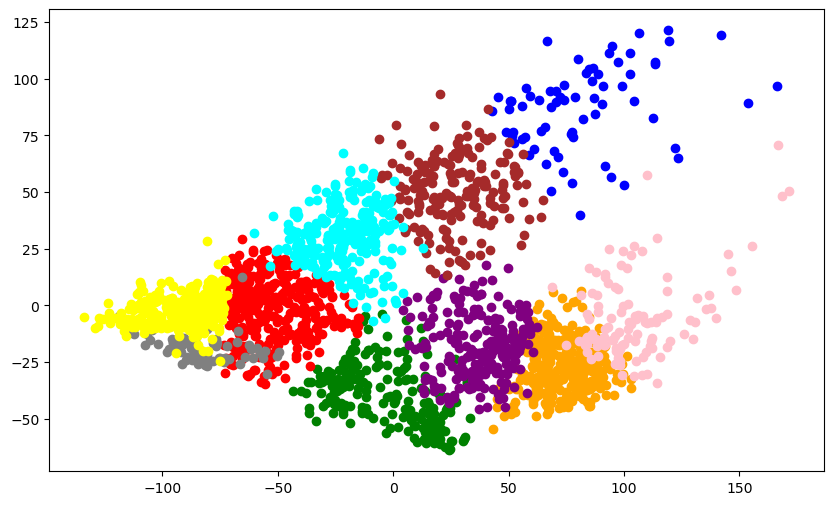

In [29]:
# Plotting the points graph
plt.figure(figsize=(10, 6))
plt.rcParams.update({'font.size': 10})
for cluster_id in range(n_clusters):
    cluster_points = mfcc_pca[cluster_labels == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id}', color=colormap(cluster_id))

They grey cluster seems like it is only a mixture of the red and yellow clusters, but it probably is a different in a dimension the PCA can't show. We can investigate this with a coefficient graph.

Here we will see that the grey cluster is different in it's finer details. 

How to read this graph:

0th Coefficient (C0 or MFCC0): Often represents the overall energy in the signal and is sometimes excluded in certain analyses because it can dominate the other coefficients.

1st Coefficient (C1): Captures the slope of the spectrum, essentially indicating the balance between low and high frequencies. A high first coefficient suggests more energy in the higher frequencies, while a lower value indicates more energy in the lower frequencies.

2nd Coefficient (C2): Represents the curvature of the spectrum, providing information about how quickly the spectrum changes from low to high frequencies.

Higher Coefficients (C3 and beyond): Describe finer details of the spectral shape, capturing nuances in the frequency distribution. The higher the coefficient, the less they contribute to the broad spectral shape and the more they reflect fine spectral details.

You can comment out the line plt.yscale('log') to see less details. 

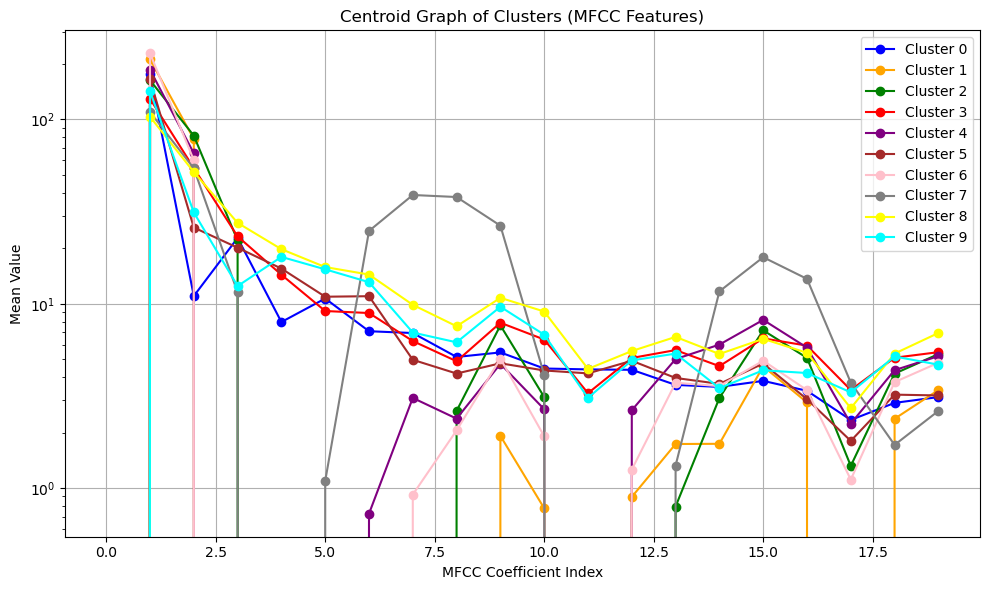

In [30]:
# Plotting the centroid graph with consistent colors
plt.figure(figsize=(10, 6))
for i in range(n_clusters):
    plt.plot(range(len(initial_centroids[i])), initial_centroids[i], label=f'Cluster {i}', marker='o', linestyle='-', color=colormap(i))

plt.title('Centroid Graph of Clusters (MFCC Features)')
plt.xlabel('MFCC Coefficient Index')
plt.ylabel('Mean Value')
plt.legend()
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.savefig('centroid_graph.png')
plt.show()

Here we will create a plot to visualize the clusters with a spectrogram below. 

You can use vmin, vmax to change the spectogram color. 

You can use plt.rcParams.update function to change font size. You can use ylim and xlim to zoom in on areas you choose. You can also uncomment the the last two lines to save a png of the outputs. 

You can change s=5 in the scatter line to make the points bigger. 

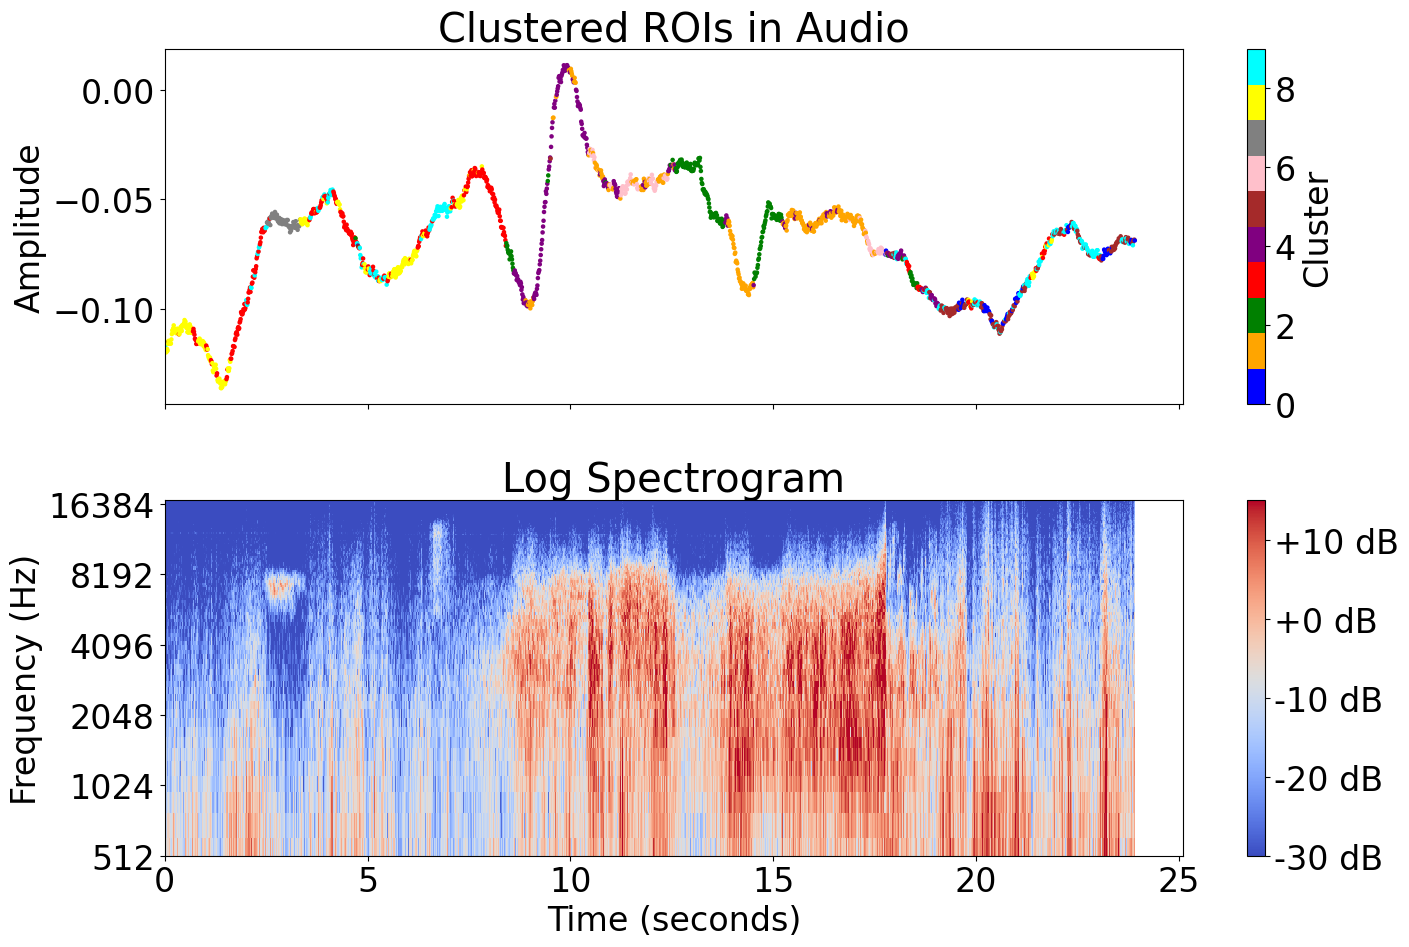

In [36]:
# Create a time axis for plotting
time = np.linspace(0, len(y) / sr, mfcc.shape[1])  # mfcc.shape[1] gives number of frames

# Create a time axis for plotting
time_clusters = np.linspace(0, len(y) / sr, mfcc.shape[1])  # mfcc.shape[1] gives number of frames

# Repeat cluster labels for each frame to align with time axis
cluster_labels = np.repeat(cluster_labels, len(time_clusters) // len(cluster_labels))

# Load the audio file again for the spectrogram
x, sampling_rate = librosa.load(file_path, sr=None)
spectrogram = librosa.feature.melspectrogram(y=x, sr=sampling_rate, n_mels=128, fmax=8000, fmin=65)
spectrogram_db = librosa.power_to_db(spectrogram)

vmin, vmax = -30, 15

# Plot the clusters and the spectrogram
plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 10))

# Scatter plot for clusters
scatter = ax[0].scatter(time, y[:len(time)], c=cluster_labels, cmap=colormap, s=5)
ax[0].set_title('Clustered ROIs in Audio')
ax[0].set_ylabel('Amplitude')
fig.colorbar(scatter, ax=ax[0], orientation='vertical', label='Cluster')

# Spectrogram plot
img = librosa.display.specshow(spectrogram_db, sr=sampling_rate, x_axis='time', y_axis='log', fmax=8000, ax=ax[1], vmin=vmin, vmax=vmax)
ax[1].set_title('Log Spectrogram')
ax[1].set_xlabel('Time (seconds)')
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set(ylim=[512, 17000])
fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

plt.tight_layout()
# Uncomment the next lines to save a png of the outputs
#fname = '_brt.png'
#plt.savefig(fname)
plt.show()


Now, we will import all the packages needed for pyspedas. 

First, we install PySPEDAS using instructions from this link: https://github.com/spedas/pyspedas

Follow all steps under the Installation Section. Next, import the following:

In [32]:
from scipy.io import readsav
import cdflib
import pyspedas
from pyspedas import time_string, time_double, tinterpol
import pytplot
from pytplot import tplot, store_data, get_data ,tlimit,xlim,ylim,tplot_options,options,split_vec,cdf_to_tplot,divide,tplot_names,get_timespan, tplot_rename, time_datetime
#import wget
from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)
import cdflib
from datetime import datetime,timedelta
import os.path
import bisect
import csv
from scipy import interpolate
import pandas as pd
import astropy.units as u,astropy.constants as const

#%matplotlib notebook
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
#import math functions 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dateutil.parser

from matplotlib import ticker, cm
import warnings 
warnings.filterwarnings("ignore")


from warnings import simplefilter 
simplefilter(action='ignore', category=DeprecationWarning)

First, specify the time range of the WAV file uploaded for the magnetic field data type and the span-i data type. 

For the RTN data and the proton energy flux data. 

In [33]:
#specify time range
trange=['2021-04-29/07:30','2021-04-29/08:30']

#specify magnetic field data type to plot
#mag_datatype = 'mag_rtn_4_sa_per_cyc' #this is not the highest resolution (downsampled to 4 samples per cycle')
mag_datatype = 'mag_rtn' #uncomment this line for highest resolution

#download magnetic field data from the FIELDS instrument on PSP
mag_vars = pyspedas.psp.fields(trange=trange, datatype=mag_datatype, level='l2', time_clip=True)

#specify time range
trange=['2021-04-29/07:30','2021-04-29/08:30']

#specify span-i data type to plot
spi_datatype='spi_sf00_l3_mom' #protons
spi_vars = pyspedas.psp.spi(trange=trange, datatype=spi_datatype, level='l3', time_clip=True)

05-Aug-24 19:00:59: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2021/
05-Aug-24 19:00:59: File is current: psp_data/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021042906_v02.cdf
05-Aug-24 19:01:19: Time clip was applied to: psp_fld_l2_mag_RTN
05-Aug-24 19:01:19: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn/2021/
05-Aug-24 19:01:20: File is current: psp_data/fields/l2/mag_rtn/2021/psp_fld_l2_mag_rtn_2021042906_v02.cdf
05-Aug-24 19:01:20: Time clip was applied to: psp_fld_l2_quality_flags
05-Aug-24 19:01:20: Downloading remote index: https://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spi/l3/spi_sf00_l3_mom/2021/
05-Aug-24 19:01:20: File is current: psp_data/sweap/spi/l3/spi_sf00_l3_mom/2021/psp_swp_spi_sf00_l3_mom_20210429_v04.cdf
05-Aug-24 19:01:21: Time clip was applied to: psp_spi_QUALITY_FLAG
05-Aug-24 19:01:21: Time clip was applied to: psp_spi_DENS
05-Aug-24 19:01:21: Time clip was applied to: psp_spi_VEL_INST

Here we are creating a variable for the PSP RTN data.

You can uncomment the last two lines to print the outputs if you wish. 

In [34]:
b=get_data('psp_fld_l2_mag_RTN')
#print(b.times)
#print(b.y)

Here we are creating a new array to change the time variable for the cluster graph to plot it with the PSP data. 

In [37]:
b_times_original= b.times
start_time=b_times_original[0]
stop_time=b_times_original[-1]
new_timelength=len(time_clusters)
new_cluster_time = np.linspace(start_time, stop_time, new_timelength)

Now we access the proton energy flux vs energy. 

In [38]:
spi_eflux_v_energy = get_data('psp_spi_EFLUX_VS_ENERGY')

spi_times = spi_eflux_v_energy.times
spi_nrg_flux = spi_eflux_v_energy.y
spi_nrg_vals = spi_eflux_v_energy.v

datetime_spi = time_datetime(spi_times)
times_spi_repeat = np.repeat(np.expand_dims(datetime_spi,1),32,1) #repeat time array for each energy bin (32 of them)

Here we are plotting the data using the new time. We are also turning that time into datetime using the time_datetime function. 

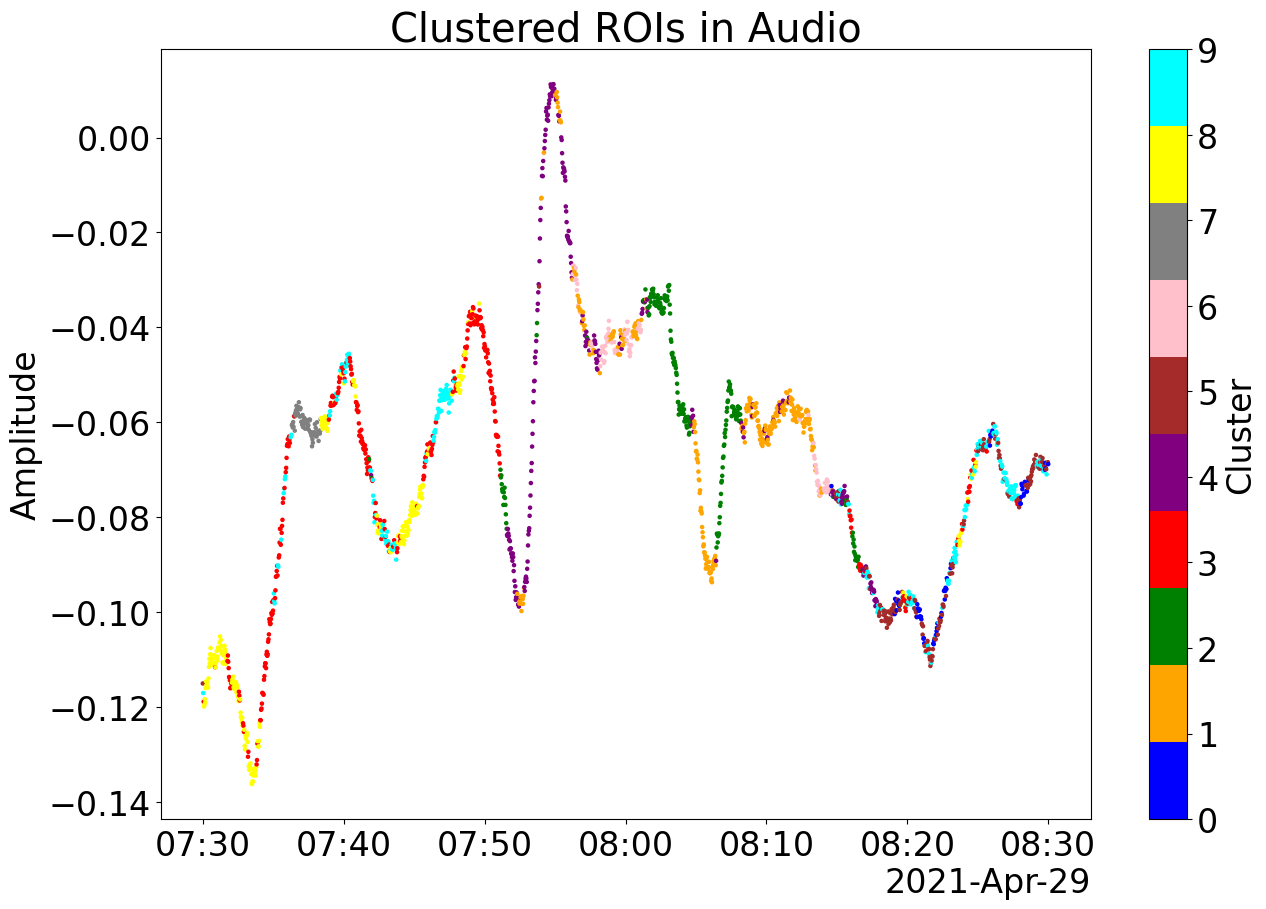

In [51]:
import matplotlib as mpl

# Repeat cluster labels for each frame to align with time axis
cluster_labels = np.repeat(cluster_labels, len(new_cluster_time) // len(cluster_labels))

vmin, vmax = -30, 15

# Plot the clusters and the spectrogram
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(15, 10))

# Scatter plot for clusters
scatter = ax.scatter(time_datetime(new_cluster_time), y[:len(new_cluster_time)], c=cluster_labels, cmap=colormap, s=5)
ax.set_title('Clustered ROIs in Audio')
ax.set_ylabel('Amplitude')
fig.colorbar(scatter, ax=ax, orientation='vertical', label='Cluster')

Now, we will get the data and create variables for br, bn, and bt. 

In [52]:
b = get_data('psp_fld_l2_mag_RTN')
#Split magnetic field vector, B, into 3 separate tplot variables (xyz = rtn)
split_vec('psp_fld_l2_mag_RTN')

['psp_fld_l2_mag_RTN_x', 'psp_fld_l2_mag_RTN_y', 'psp_fld_l2_mag_RTN_z']

In [53]:
#access data in magnetic field components
br = get_data('psp_fld_l2_mag_RTN_x')

#note that times are stored in arrays as br.times and br.y for the values
bt = get_data('psp_fld_l2_mag_RTN_y')
bn = get_data('psp_fld_l2_mag_RTN_z')

#define magnitude |B| and store as tplot variable
bmag = np.sqrt(br.y**2 + bt.y **2 + bn.y**2)

In [54]:
times_datetime = time_datetime(br.times)
br_vals = br.y
bt_vals = bt.y
bn_vals = bn.y

Now we will graph it all together. 

You can change the xlim = [datetime(2021, 4, 29, 8,0,0), datetime(2021, 4, 29, 8,20,0)] line to zoom in on a specific cluster to investigate what is going on in each cluster in BT or in the proton energy flux. 

You can add a set(ylim =[99,99]) to any ax to zoom in. 

05-Aug-24 19:13:16: /tmp/ipykernel_534/52904859.py:18: RuntimeWarning: divide by zero encountered in log10
  np.log10(spi_nrg_flux),cmap='terrain')

05-Aug-24 19:13:16: /srv/conda/envs/notebook/lib/python3.10/site-packages/matplotlib/dates.py:454: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  d = d.astype('datetime64[us]')



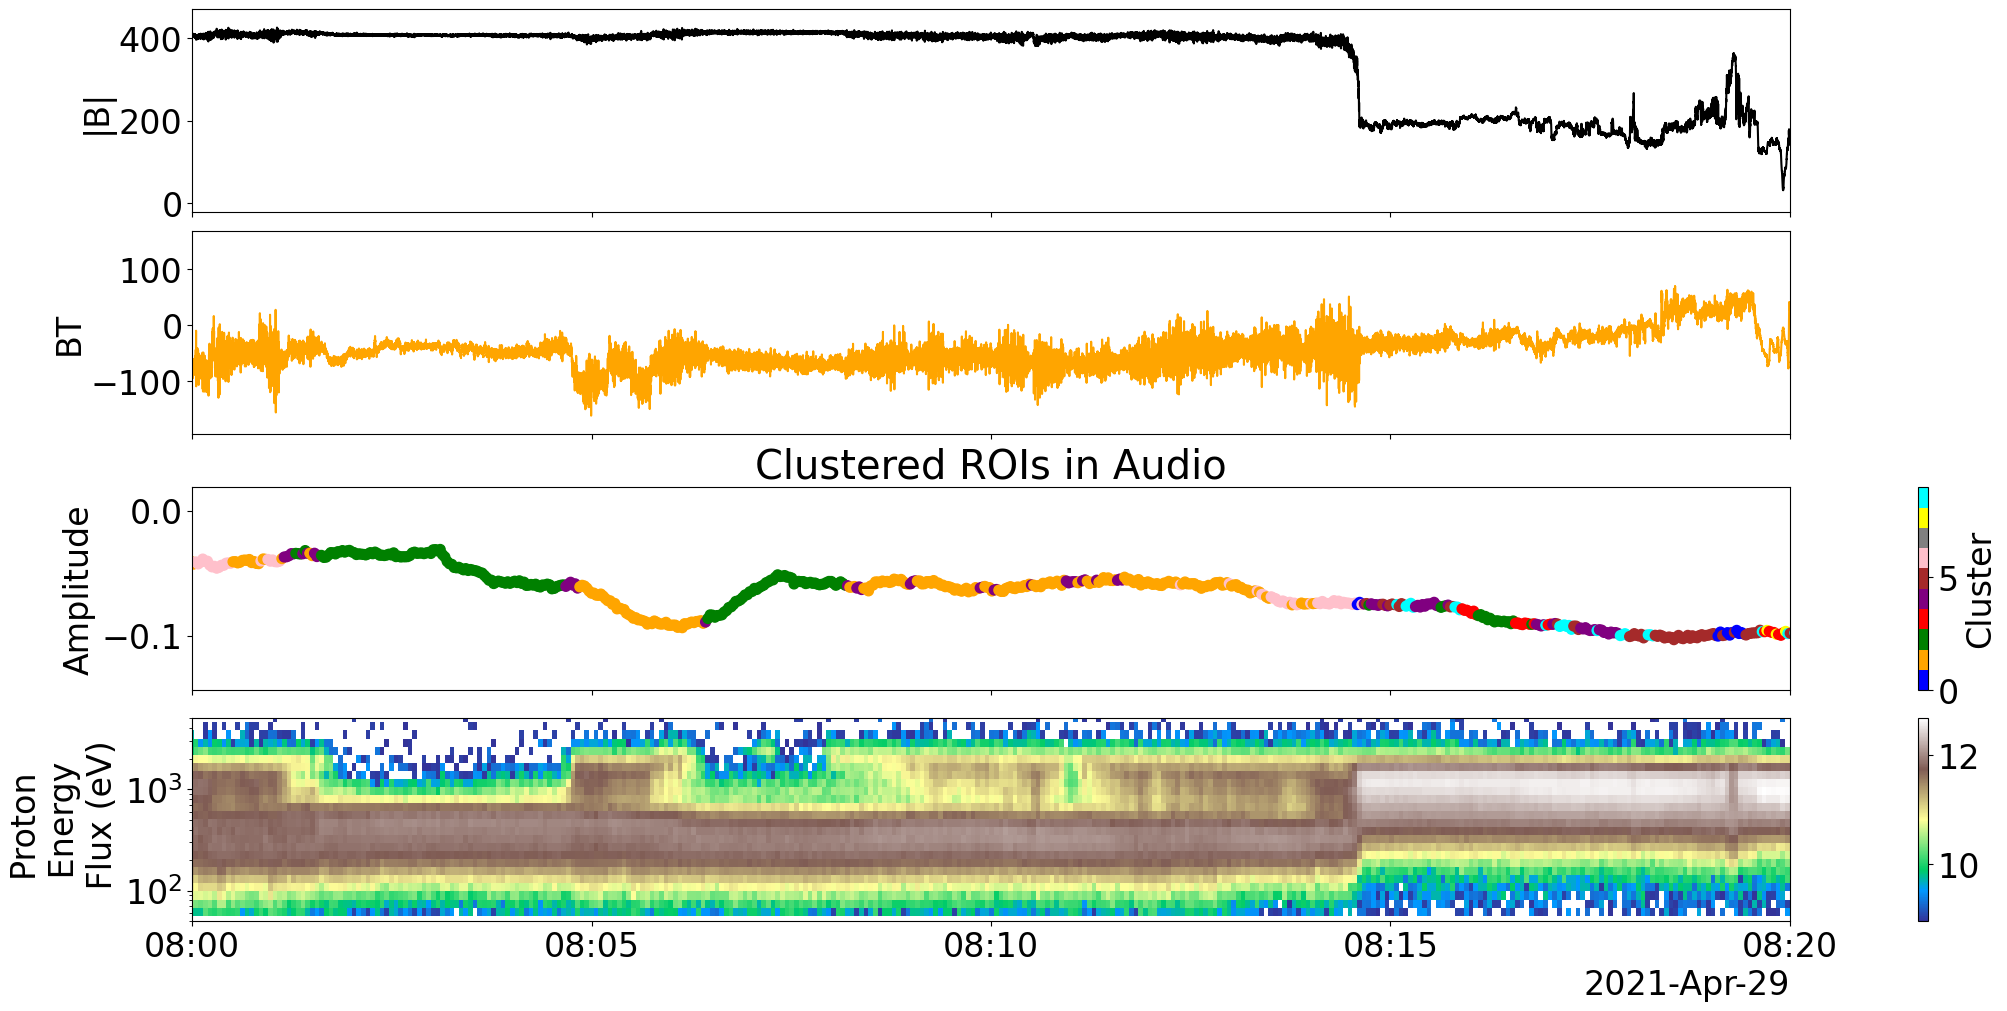

In [55]:
xlim = [datetime(2021, 4, 29, 8,0,0), datetime(2021, 4, 29, 8,20,0)]


plt.rcParams.update({'font.size': 24}) #set global font size
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(20, 10), layout='compressed')

ax[0].plot(times_datetime, bmag,label=r'$|B|$',color='black')
ax[0].set_ylabel('|B|')
ax[0].set(xlim = xlim)
ax[1].plot(times_datetime, bt_vals,label=r'$B_T$',color='orange')
ax[1].set_ylabel('BT')
ax[2].scatter(time_datetime(new_cluster_time), y[:len(new_cluster_time)], c=cluster_labels, cmap=(mpl.colors.ListedColormap(['blue', 'orange', 'green', 'red','purple','brown','pink','grey','yellow','cyan'])
        .with_extremes(under='yellow', over='magenta')), s=50)
ax[2].set_title('Clustered ROIs in Audio')
ax[2].set_ylabel('Amplitude')
fig.colorbar(scatter, ax=ax[2], orientation='vertical', label='Cluster')
s_spi_nrg = ax[3].pcolormesh(times_spi_repeat,spi_nrg_vals,
         np.log10(spi_nrg_flux),cmap='terrain')
cbar_spi_nrg = plt.colorbar(s_spi_nrg)
ax[3].set_yscale('log')
ax[3].set(
    ylabel = 'Proton \n Energy \n Flux (eV)',
    ylim = [50,5e3]
)
fname = 'rtn.png'
plt.savefig(fname)
plt.show()